In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

from policy import ResNet, ConvNet

# Set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from jem import JointEmbeddingModel, get_data

lr = 0.001
epochs = 10
batch_size = 128
input_state_embed = 64
hidden_state_embed = 32
output_state_embed = 16 
exp_embed = 32
output_exp_embed = 16

model_name = "net"
session_name = "falcon"
board_size = 5
board_name = f'{board_size}x{board_size}'
resnet = False

model_type = "resnet" if resnet else "convnet"

agents_to_sample = [0, 10, 20, 60, 100, 500, 1000]
cases_to_sample = 50

full_model_path = f"../models/saved_sessions/{model_type}/board_size_{board_size}/{session_name}/"

def load_model(full_name, model_name, epoch):
    model_path = full_name + model_name + "_" + str(epoch) + ".keras"
    if resnet:
        model = ResNet(board_size, model_path)
    else:
        model = ConvNet(board_size, model_path)
    return model

agents = [load_model(full_model_path, model_name, epoch) for epoch in agents_to_sample]

# Load the data
states, explanations, labels, max_sent_len, vocab = get_data(agents, cases_to_sample, board_size)

vocab_size = len(vocab)

print(states.shape, explanations.shape, labels.shape, max_sent_len, vocab_size)

# Shuffle the data
indices = np.arange(states.shape[0])
np.random.shuffle(indices)
states = states[indices]
explanations = explanations[indices]
labels = labels[indices]

# Split the data into 60% training, 20% validation, and 20% test
split1 = int(0.6 * states.shape[0])
split2 = int(0.8 * states.shape[0])

train_states = states[:split1]
train_explanations = explanations[:split1]
train_labels = labels[:split1]

val_states = states[split1:split2]
val_explanations = explanations[split1:split2]
val_labels = labels[split1:split2]

test_states = states[split2:]
test_explanations = explanations[split2:]
test_labels = labels[split2:]



Positive cases for concept: one_eye: 77it [00:15,  4.90it/s]                        
Positive cases for concept: two_eyes: 100%|██████████| 50/50 [05:34<00:00,  6.70s/it]
Positive cases for concept: center_dominance: 156it [00:08, 17.69it/s]                       
Positive cases for concept: area_advantage: 449it [00:09, 49.69it/s]                       

(1000, 5, 5, 5) (1000, 8) (1000,) 8 18


### Train the joint embedding model

In [44]:
jem = JointEmbeddingModel(vocab_size=vocab_size, max_sent_len=max_sent_len, board_size=board_size, learning_rate=lr)

jem.fit(train_states, train_explanations, train_labels, val_states, val_explanations, val_labels, epochs=epochs, batch_size=batch_size)

jem.save_model('../models/jem/joint_embedding_model.keras')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 5, 5)]    0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 5, 5, 32)     1472        ['input_3[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 5, 5, 32)     9248        ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 5, 5, 32)     9248        ['conv2d_5[0][0]']               
                                                                                            

2024-02-22 21:15:18.095766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


5/5 [==============================] - 8s 557ms/step - loss: 35.8159 - combined_output_loss: 35.8159 - val_loss: 28.5286 - val_combined_output_loss: 28.5286
Epoch 2/10
5/5 [==============================] - 0s 93ms/step - loss: 29.0114 - combined_output_loss: 29.0114 - val_loss: 26.9537 - val_combined_output_loss: 26.9537
Epoch 3/10
5/5 [==============================] - 0s 88ms/step - loss: 24.2969 - combined_output_loss: 24.2969 - val_loss: 21.4059 - val_combined_output_loss: 21.4059
Epoch 4/10
5/5 [==============================] - 0s 87ms/step - loss: 21.6793 - combined_output_loss: 21.6793 - val_loss: 20.8211 - val_combined_output_loss: 20.8211
Epoch 5/10
5/5 [==============================] - 0s 86ms/step - loss: 20.0009 - combined_output_loss: 20.0009 - val_loss: 22.9062 - val_combined_output_loss: 22.9062
Epoch 6/10
5/5 [==============================] - 0s 87ms/step - loss: 19.8709 - combined_output_loss: 19.8709 - val_loss: 20.3814 - val_combined_output_loss: 20.3814
Epoch 7/

concept breakdown: {'null': 0, 'one_eye': 9, 'two_eyes': 9, 'center_dominance': 10, 'area_advantage': 14}


--- Test Results ---
recall@1: 0.0%
recall@2: 21.43%
recall@3: 42.86%


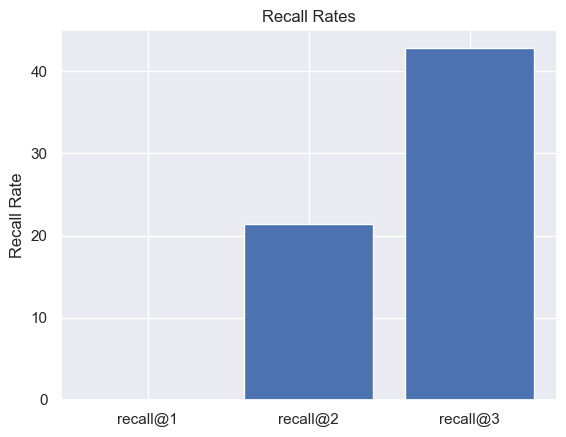

In [45]:
# Import necessary modules
from sklearn.manifold import TSNE
import seaborn as sns
import colorcet as cc
from jem import data

# Define necessary variables
explanation_list = data.get_explanation_list()
confusion_matrix = data.init_confusion_matrix()
encoded_explanations = [data.convert_explanation_to_integers(explanation, vocab, max_sent_len) for explanation in (explanation_list)]

gt_dict = {'null':0, 'one_eye': 0, 'two_eyes':0, 'center_dominance':0, 'area_advantage':0}

explanation_predictions = []
predicted_explanation_embeddings = []
predicted_state_embeddings = []

recall_at_1 = 0
recall_at_2 = 0
recall_at_3 = 0

count_ignore = 0

# Get the embeddings
# The TSN-E visualizations is created using the models’ training dataset.
for i in range(len(test_states)):
    if test_labels[i] == 1:
        # Skip the misaligned datacases
        count_ignore += 1
        continue

    l2_norm_arr = []

    total_state_embeddings = []
    total_explanation_embeddings = []

    for j, explination in enumerate(explanation_list):
        get_j_encoded_explanation = data.convert_explanation_to_integers(explination, vocab, max_sent_len)

        state_embed, exp_embed, _ = jem.predict(test_states[i], test_explanations[i])
        total_state_embeddings.append(state_embed)
        # Get the explination converted to a string
        total_explanation_embeddings.append(exp_embed)

        # Calculate the L2 norm
        differences = state_embed - exp_embed
        l2_norm = np.linalg.norm(differences, axis=1, ord=2)
        l2_norm_arr.append(l2_norm)

    min_values = sorted(range(len(l2_norm_arr)), key = lambda sub: l2_norm_arr[sub])[:3]
    predicted_index = np.argmin(np.array(l2_norm_arr))

    gt_key = data.convert_integers_to_explanations(test_explanations[i], vocab)
    key_at_1 = data.convert_integers_to_explanations(encoded_explanations[min_values[0]], vocab)
    key_at_2 = data.convert_integers_to_explanations(encoded_explanations[min_values[1]], vocab)
    key_at_3 = data.convert_integers_to_explanations(encoded_explanations[min_values[2]], vocab)

    gt_dict[gt_key] += 1
    confusion_matrix[gt_key][key_at_1] += 1
    if gt_key == key_at_1:
        recall_at_1 += 1
    if gt_key == key_at_1 or gt_key == key_at_2:
        recall_at_2 += 1
    if gt_key == key_at_1 or gt_key == key_at_2 or gt_key == key_at_3:
        recall_at_3 += 1
    
    explanation_predictions.append(data.translate_explanation(explanation_list[predicted_index]))
    predicted_explanation_embeddings.append(total_explanation_embeddings[predicted_index])
    predicted_state_embeddings.append(total_state_embeddings[predicted_index])

recall_at_1_percent = round((recall_at_1/float(len(test_states) - count_ignore)) * 100, 2)
recall_at_2_percent = round((recall_at_2/float(len(test_states) - count_ignore)) * 100, 2)
recall_at_3_percent = round((recall_at_3/float(len(test_states) - count_ignore)) * 100, 2)

print("concept breakdown: " + str(gt_dict))
print("\n")
print("--- Test Results ---")
print(f"recall@1: {recall_at_1_percent}%")
print(f"recall@2: {recall_at_2_percent}%")
print(f"recall@3: {recall_at_3_percent}%")

# Plot the recall rates
fig, ax = plt.subplots()
ax.bar(['recall@1', 'recall@2', 'recall@3'], [recall_at_1_percent, recall_at_2_percent, recall_at_3_percent])
ax.set_ylabel('Recall Rate')
ax.set_title('Recall Rates')
plt.show()

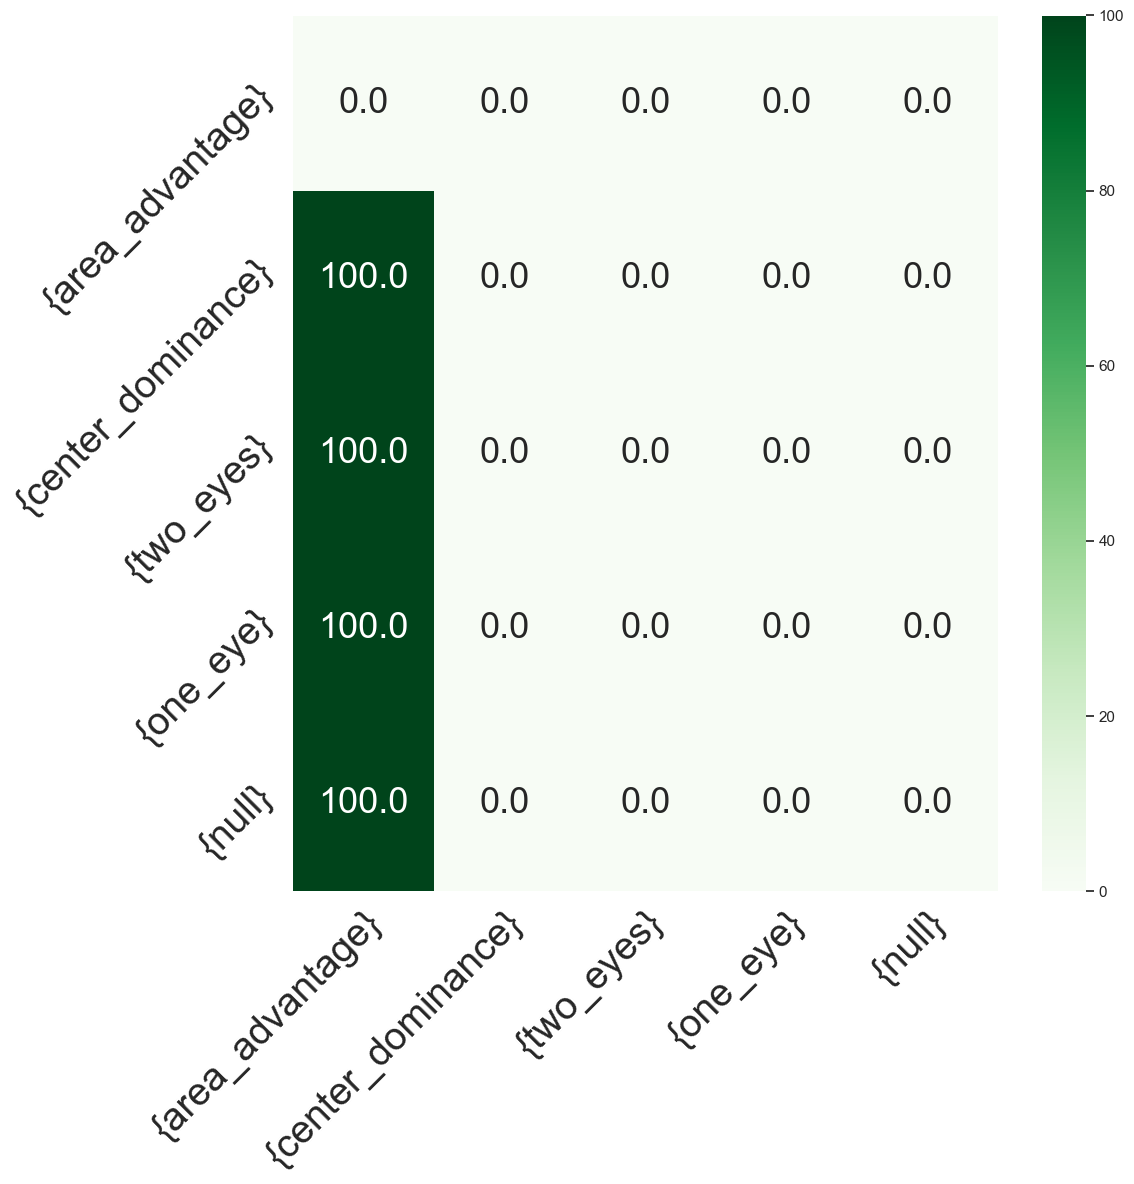

In [46]:
import pandas as pd
import seaborn as sne

keys_ = list(confusion_matrix.keys())
arr2 = []
for i in keys_:
    class_sum = float(sum(confusion_matrix[i].values()))
    class_arr = []
    for j in keys_:
        calc_ = 0 if class_sum == 0 else confusion_matrix[i][j] / class_sum
        class_arr.append(calc_)
    arr2.append(class_arr)

labels = ['{area_advantage}', '{center_dominance}', '{two_eyes}', '{one_eye}', '{null}']
df_cm2 = pd.DataFrame(np.array(arr2)*100, labels, labels)
fig, ax = plt.subplots(figsize=(12,12)) 
sne.set_theme(font_scale=1.0) # for label size
sne.heatmap(df_cm2, annot=True, annot_kws={"size": 26}, cmap="Greens", fmt='.1f') # font size
plt.xticks(rotation=45, fontsize=28, horizontalalignment="right", verticalalignment="top", rotation_mode="anchor")
plt.yticks(rotation=45, fontsize=28, horizontalalignment="right", verticalalignment="bottom", rotation_mode="anchor")
# plt.show()
plt.tight_layout()

[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.000s...
[t-SNE] Computed neighbors for 42 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 0.047882
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.501728
[t-SNE] KL divergence after 1000 iterations: -0.150857


/var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/ipykernel_14736/2680563613.py:17: UserWarning: The palette list has more values (5) than needed (1), which may not be intended.
  sns.scatterplot(x=state_embed_tsne[:,0], y=state_embed_tsne[:,1], hue=explanation_predictions, legend='full', palette=palette)


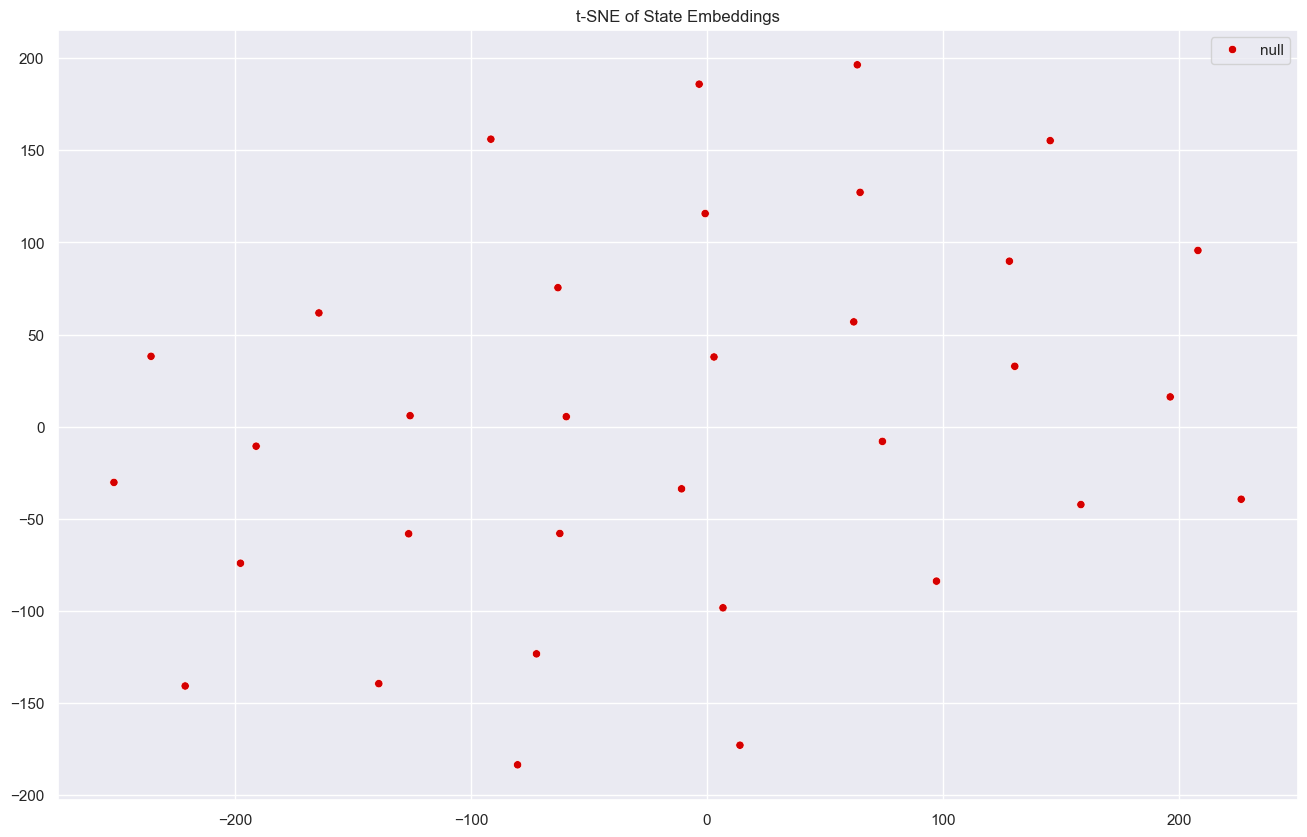

In [51]:
new_state_embed = []

for list_ in predicted_state_embeddings:
    new_state_embed.append(list_[0])


new_state_embed = np.array(new_state_embed)

# Fit the t-sne
tsne = TSNE(n_components=2, verbose=1)
state_embed_tsne = tsne.fit_transform(new_state_embed)


# Plot the t-sne
palette = sns.color_palette(cc.glasbey, 5)
plt.figure(figsize=(16,10))
sns.scatterplot(x=state_embed_tsne[:,0], y=state_embed_tsne[:,1], hue=explanation_predictions, legend='full', palette=palette)
plt.title('t-SNE of State Embeddings')
plt.plot()
plt.show()